# Mathematical Methods in Data Science and Signal Processing
Homework assignment 2<br>
by: Ariel Kantorovich<br>
 ID: 308345891<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cvxpy as cp
import networkx as nx
from concurrent.futures import ThreadPoolExecutor

# Question 1:

In [8]:
# Parameters
n = 1000
mu = 0.0
sigma = 1.0
Iteration = 2000
# Generate Random Matrix
S = sigma * np.random.randn(n, n) + mu
P = (S @ S.T) / 2.0
# Calculate Ground True Eigen Vector
eig_val_true, eig_vec_true = scipy.sparse.linalg.eigsh(P, k=1, which='LA')

Implement Power iteration loop

In [9]:
relative_error = np.zeros((Iteration, ))
b0 = np.random.randn(n, 1)
b_prev = b0
v_norm = np.linalg.norm(eig_vec_true, ord=2)
for i in range(Iteration):
    temp = P @ b_prev
    temp_norm = np.linalg.norm(temp, ord=2)
    b_next = temp / temp_norm
    b_prev = b_next
    # Calculate Error
    relative_error[i] = min(np.linalg.norm(-1.0 * b_next - eig_vec_true, ord=2) / v_norm, np.linalg.norm(1.0 * b_next - eig_vec_true, ord=2) / v_norm)

compare theoretical and empirical results

In [13]:
w2, u2 = scipy.sparse.linalg.eigsh(P, k=2, which='LA')
L1 = w2[0]
L2 = w2[1]
expected_slope = np.log(L1/L2)
slope, intercept = np.polyfit(range(Iteration), np.log(relative_error), 1)
print('\nExpected slope: {:.2}'.format(expected_slope))
print('Actual slope: {:.2}'.format(slope))
print('\nTotal Number of iterations: {}'.format(Iteration))


Expected slope: -0.0041
Actual slope: -0.0041

Total Number of iterations: 2000


Plot relative_error

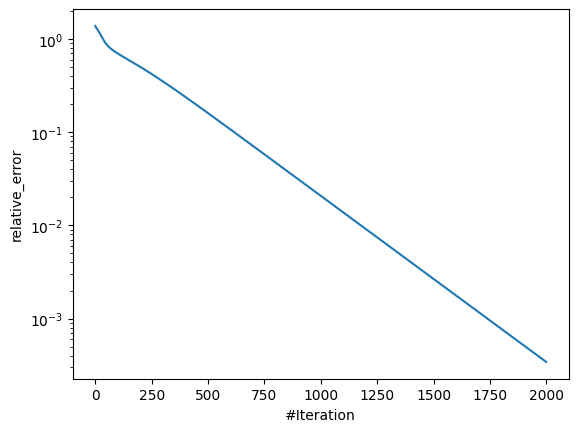

([<matplotlib.lines.Line2D at 0x7fc63693d100>],
 Text(0.5, 24.0, '#Iteration'),
 Text(24.140625000000007, 0.5, 'relative_error'),
 None)

In [14]:
t = np.arange(Iteration)
plt.semilogy(t, relative_error), plt.xlabel('#Iteration'), plt.ylabel('relative_error'), plt.show()

The results of the experiment are shown in Figure above. I chose a semi-logarithmic scale on the
Y-axis, since the error is predicted to decay like $(\frac{\lambda_1}{\lambda_2})^{k}$ where k-num iteration, $\lambda_{1}$ is highest eigen value and $\lambda_{2}$ is the second. This ratio becomes a linear function of k in this semi-logarithmic scale that make sense with theorem. The empircal slope that we observe on the graph is very close to $|\lambda_{T} - \lambda_{1} = O(\frac{|\lambda_{2}|^{k}}{|\lambda_{1}|})|$ as we show in the class.
Finally, a unit eigenvector v and its negation v are both unit eigenvectors corresponding to the same eigenvalue. Thus, depending on its initialization, the power iteration may converge to the precalculated ground truth unit eigenvector or to its negation. This explains why the relative
error is defined as the minimum over a ground truth eigenvector or its negation of the ordinary relative error of our current estimate.

# Question 2:

Generate Signal and circular shift

In [2]:
# Parameters
Nx = 50
n = 2000
# Generate X
x = np.zeros(Nx)
x[0:10] = 1
# Generate gaussian moise
sigma = 0
epsilon = np.random.normal(0, sigma, size=(Nx, n))
# Generate circulate dataset
shifts = np.random.randint(0, Nx, size=(n, 1))
mask = np.tile(np.arange(0, Nx), (n, 1)) + shifts
mask %= Nx
Y= x[mask.T] + epsilon

Part (a):<br> I choose  $\tau_{g} = 3$, $\sigma = 0$, $t=10$

In [3]:
def diffusion_map_main(Y, tg, d, t, sig=0):
    # Initialize the W matrix
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            norm_diff = np.linalg.norm(Y[:, i] - Y[:, j])
            W[i,j] = W[j,i] = np.exp(-norm_diff / tg) # Since W is symmetric
    # Build D
    deg_W = np.sum(W, axis=1)
    D = np.diag(deg_W)
    D_inv = np.diag(1 / deg_W)
    # Construct Matrix M
    M = D_inv @ W
    # Construct S
    S = (D ** 0.5) @ M @ (D_inv ** 0.5)
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(S, k=d+1, which='LA')
    PHI = (D_inv ** 0.5) @ eigenvectors
    phi = (eigenvalues[:-1] ** t) * eigenvectors[:, :-1]
    plt.title(f"With Noise, $\epsilon={sig}$")
    plt.scatter(phi[:, 0], phi[:, 1], label=f'$\\tau_{{g}} = {tg}$'), plt.legend(), plt.show()


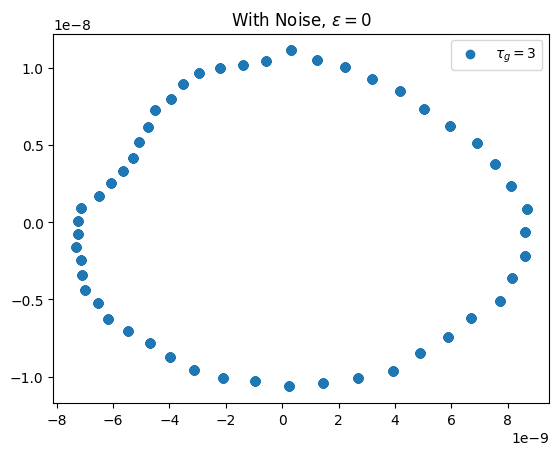

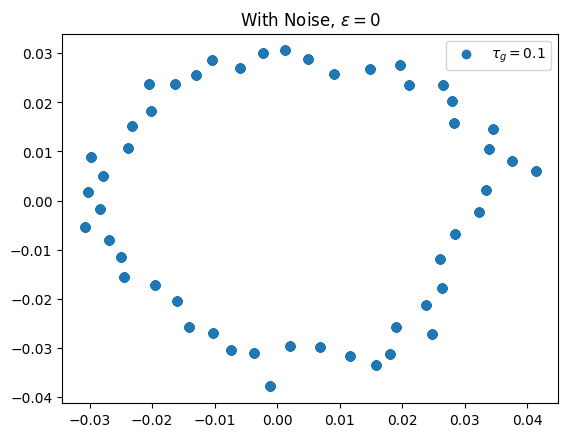

In [4]:
tg = 3
d = 2
t = 10
diffusion_map_main(Y, tg, d, t)
tg = 1/10
diffusion_map_main(Y, tg, d, t)

Answer (a) <br>
We apply a diffusion map and reduce dimension from 2K to 2 such we can plot results.
We see in the plot that we get circular geometry this makes sense because we generate observation $y_{1}, y_{2}, ..., y_{n}$ where each $y_{i}$ is step signal with circular shift, Conclusion in the plot we can see this circular shift geometry.
while the scale is too low $\tau_{g}/10$, it is actually expanding the distance between the observations and made the graph sparsely with non-circular structure.while the scale is too low, it is actually expanding the distance between the observations and made the graph sparsely with non-circular structure.

Part (b):<br> I choose  $\tau_{g} = 3$, $\sigma = [0.1, 1, 10]$, $t=10$

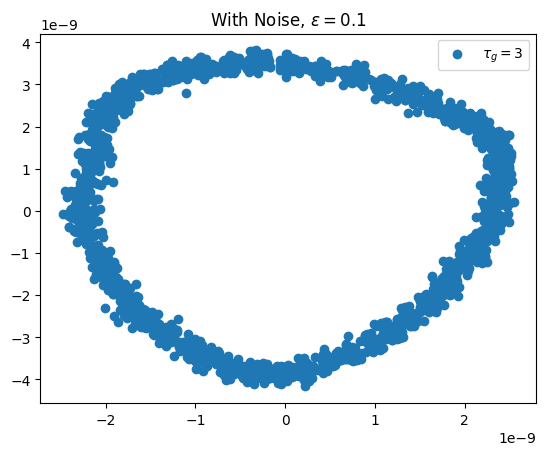

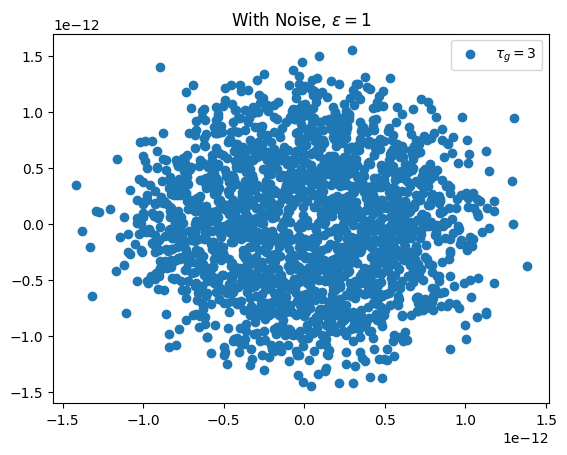

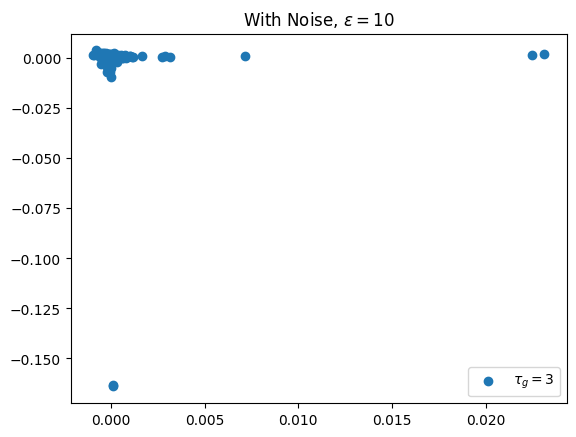

In [5]:
# Parameters
tg = 3
d = 2
t = 10
# Generate gaussian moise
sigma_list = [0.1, 1, 10]
# Generate circulate dataset
shifts = np.random.randint(0, Nx, size=(n, 1))
mask = np.tile(np.arange(0, Nx), (n, 1)) + shifts
mask %= Nx
for sigma in sigma_list:
    epsilon = np.random.normal(0, sigma, size=(Nx, n))
    Y= x[mask.T] + epsilon
    diffusion_map_main(Y, tg, d, t, sigma)

We can see in our results where the variance is small $\sigma = 0.1$ that the diffusion map succeeds in handling the noise and we get a circular structure but when the noise is high diffusion map does not succeed in observing circular structure. It makes sense because we have a very low SNR In the original space our data is messy and not organized on real structure.

# Question 3:

In [14]:
def generate_random_grapg(p_intra=0.1, num_vertices=20):
    p_inter = 1 - p_intra
    # Create a graph
    G = nx.Graph()

    # Add nodes to sets A and B
    nodes_A = range(1, num_vertices + 1)
    nodes_B = range(num_vertices + 1, 2 * num_vertices + 1)
    G.add_nodes_from(nodes_A, bipartite=0)
    G.add_nodes_from(nodes_B, bipartite=1)

    # Generate edges within set A
    for u in nodes_A:
        for v in nodes_A:
            if u != v:
                if np.random.rand() < p_intra:
                    G.add_edge(u, v)

    # Generate edges within set B
    for u in nodes_B:
        for v in nodes_B:
            if u != v:
                if np.random.rand() < p_intra:
                    G.add_edge(u, v)

    # Generate edges between sets A and B
    for u in nodes_A:
        for v in nodes_B:
            if np.random.rand() < p_inter:
                G.add_edge(u, v)

    # Check the adjacency matrix (optional)
    adj_matrix = nx.adjacency_matrix(G).todense()
    return adj_matrix


adj_matrix = generate_random_grapg()

In [15]:
G_simple = np.concatenate((np.ones(20), np.zeros(20))) # 1 if belong to A and 0 to B
G_simple_x, G_simple_y = np.meshgrid(G_simple, G_simple)
G_simple_2D = np.logical_xor(G_simple_x,G_simple_y)
adj_matrix_simple = G_simple_2D.astype(int)

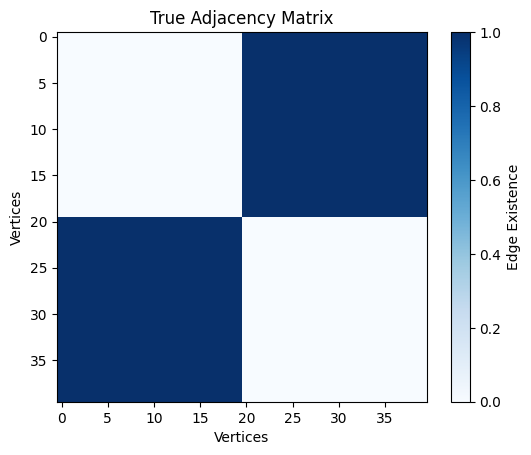

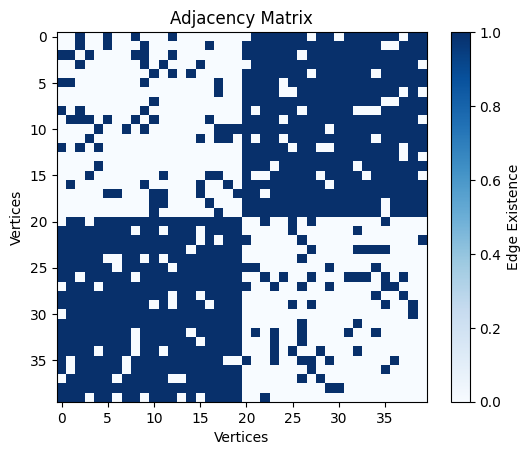

In [16]:
plt.imshow(adj_matrix_simple, cmap='Blues', interpolation='none')
plt.colorbar(label='Edge Existence')
plt.title('True Adjacency Matrix')
plt.xlabel('Vertices')
plt.ylabel('Vertices')
plt.show()

plt.imshow(adj_matrix, cmap='Blues', interpolation='none')
plt.colorbar(label='Edge Existence')
plt.title('Adjacency Matrix')
plt.xlabel('Vertices')
plt.ylabel('Vertices')
plt.show()

In [25]:
T = 50 # Iteration
P_list = np.arange(0.1, 0.55, 0.05, dtype=np.float16)
errors = np.zeros((len(P_list), T))

i = 0
for p in P_list:
    for t in range(T):
        G = generate_random_grapg(p_intra=p, num_vertices=20)
        n = G.shape[0]
        # create X var to solve optimization problem
        X = cp.Variable((n, n), symmetric=True)
        # Define Objective
        objective = cp.Maximize(0.5 * cp.sum((cp.multiply(G, (1 - X)))))
        # Define Constraint
        constraints = [X >> 0, cp.diag(X) == cp.Parameter((n,), value=np.ones(n))]
        # Define the Convex optimization problem with constraint
        prob = cp.Problem(objective, constraints)
        # Solve
        result = prob.solve()
        solution = X.value
        # solution is +/-1 by definition, need to manipulate all the neg vals to zeros
        G_estimate = np.where(solution<0, 0, 1)
        # Calculate the average clustering error
        error = np.sum(np.equal(G_estimate, adj_matrix_simple))/(G_estimate.size)
        # Add the error to the list of errors
        errors[i,t] = error
    i += 1

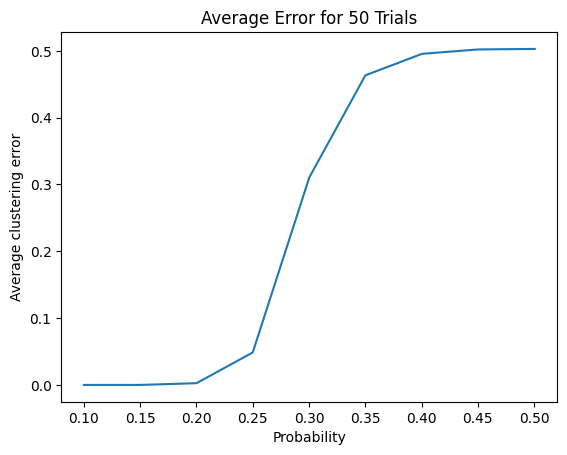

In [32]:
errors = np.mean(errors, axis=1)
# Plot Error
plt.plot(P_list, errors)
plt.title('Average Error for {} Trials'.format(T))
plt.xlabel('Probability')
plt.ylabel('Average clustering error')
plt.show()

The clustering error is small for very small p’s and grows
rapidly as p increases.

# Question 4:

**Theory Part:**

We show that the given expression for $e^{j\theta_{al}}$ minimizes $$G(z) := \|h-\hat{h} z\|_{2}^{2}$$ subject to $|z|=1$.

This function can be written as splittable problem that we minimize every j example. Using Lagrange multipliers, we get the following optimization problem:



$$
\underset{z}{\text{minimize}} \sum_{j=1}^{n} |\hat{h}^{*}_{j} h_{j} - z|^{2} - \lambda (z^{T}z - 1)
$$

We obtain that the optimal solution of the constrained optimization problem must satisfy the following equation for some $\lambda \in \mathbb{R}$:

$$0 = \nabla G(z) + 2 \lambda z \Leftrightarrow \sum_{j=1}^{n} (\hat{h}^{*}_{j} h_{j} - z) + \lambda z = 0$$

and we get:

$$ z = \frac{1}{n - \lambda} \hat{h}^{*} h$$

Obviously, $|z|= 1$ if and only if $n - \lambda = |\hat{h}^{*}h|$, so we finish the proof.

Now we're going to write the error measurement in implicit form:

$$\text{Error}(\hat{h}) = \frac{\|h-\hat{h} \cdot e^{j\theta_{al}}\|_{2}}{\|h\|_{2}} = \frac{\|h-\hat{h} \cdot e^{j\theta_{al}}\|_{2}}{\sqrt{n}}$$

**Code Part:**

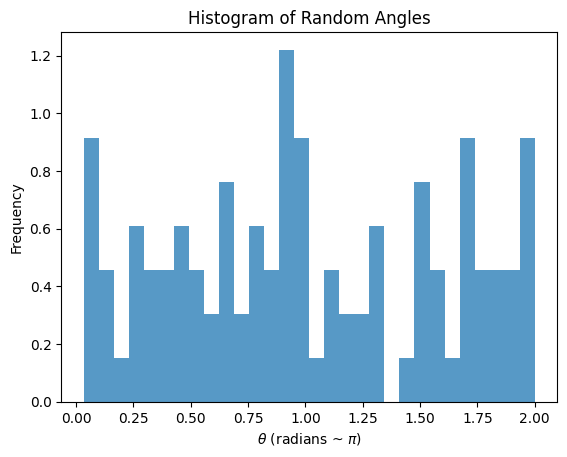

In [2]:
n = 100
theta = np.random.uniform(0, 2*np.pi, n)
# Plot histogram
theta_normalized = theta / np.pi
plt.hist(theta_normalized, bins=30, density=True, alpha=0.75)
plt.title("Histogram of Random Angles")
plt.xlabel(r"$\theta$ (radians ~ $\pi$)")
plt.ylabel("Frequency")
plt.show()

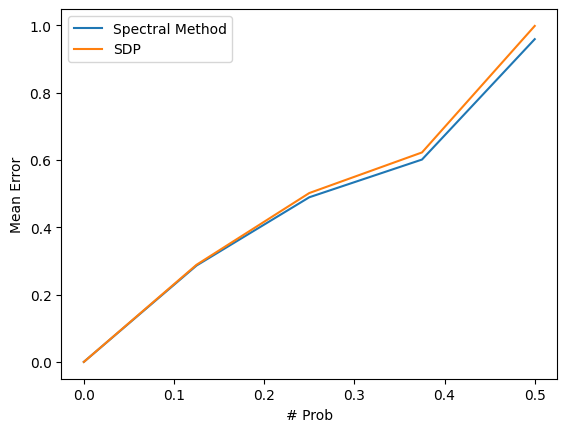

Finish !!!!


In [12]:
def Corrupt_H(H, p):
    # Initialize part
    H_corrupt = H.copy()
    n, _ = H.shape
    # corrupt loop
    for j in range(1, n):
        for k in range(j + 1, n):
            rand_num = np.random.rand()
            if rand_num <= p:
                alpha = np.random.uniform(0, 2*np.pi)
                H_corrupt[j, k] = np.exp(1j * alpha)
                H_corrupt[k, j] = np.conj(H_corrupt[j, k])
    return H_corrupt

def process_data(p):
    H_corrupt = Corrupt_H(H, p)
    SM_errors = []
    SDP_errors = []
    for _ in range(Trials):
        # Spectral Method
        eigen_val, eigen_vec = scipy.sparse.linalg.eigsh(H_corrupt, k=1, which='LM')
        SM = eigen_vec / np.abs(eigen_vec)
        align = np.dot(SM[:, 0].conj(), h)
        align /= np.abs(align)
        SM_error = np.linalg.norm(h - SM[:, 0] * align, ord=2)
        SM_errors.append(SM_error)

        # SDP Method
        H_noise = cp.Parameter((n, n), complex=True, value=H_corrupt)
        Z = cp.Variable((n, n), complex=True)
        constraints = [Z >> 0, cp.diag(Z) == cp.Parameter((n,), value=np.ones(n), complex=True), Z == Z.H]
        objective = cp.Maximize(cp.real(cp.trace(H_noise @ Z)))
        Problem = cp.Problem(objective, constraints)
        Problem.solve()
        Z_SDP = Z.value
        eigen_val, eigen_vec = scipy.sparse.linalg.eigsh(Z_SDP, k=1, which='LM')
        SDP = eigen_vec / np.abs(eigen_vec)
        align = np.dot(SDP[:, 0].conj(), h)
        align /= np.abs(align)
        SDP_error = np.linalg.norm(h - SDP[:, 0] * align, ord=2)
        SDP_errors.append(SDP_error)

    return np.mean(SM_errors), np.mean(SDP_errors)

# Initialize parameters
n = 100
theta = np.random.uniform(0, 2*np.pi, n)
h = np.exp(1j * theta)
H = np.outer(h, h.conj())
P_list = np.linspace(0, 0.5, 5)
Trials = 50

# Process data using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_data, P_list))

SM_Mean, SDP_Mean = zip(*results)

# plot Results
plt.plot(P_list, SM_Mean, label='Spectral Method')
plt.plot(P_list, SDP_Mean, label='SDP')
plt.legend(), plt.xlabel("# Prob"), plt.ylabel("Mean Error"), plt.show()
print("Finish !!!!")